# Importing appropriate libraries and modules

In [97]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.pylab import rcParams
import re
from statsmodels.graphics.tsaplots import plot_acf , plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import grangercausalitytests
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)
from pandas import Grouper
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import time
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from fbprophet import Prophet as proph
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation
from fbprophet.plot import plot_cross_validation_metric

%matplotlib inline

# SP500 and VIX

"The CBOE Volatility Index, commonly known as the VIX, is calculated from options on the SPX cash index expiring between 23-37 days.. This gives the market’s anticipation of implied volatility (IV) for the next 30 days. When the market makes a larger move down traders look for protection and bid up puts which increases the VIX. Historically, investors have been afraid of a large down move and not a big up move since most investors are long stocks."

# Reading SP500 futures data and VIX
    Source: 
    https://www.investing.com/indices/us-spx-500-futures-historical-data
    
    https://www.macrotrends.net/2603/vix-volatility-index-historical-chart

In [42]:
sp500 = pd.DataFrame(pd.read_csv("S&P500FuturesHistoricalData.csv"))
vix= pd.DataFrame(pd.read_csv("vix-volatility-index.csv"))

In [43]:
sp500.head()

Date     Price      Open      High       Low     Vol. Change %
0  May 12, 2017  2,388.75  2,390.25  2,391.50  2,384.25    1.09M   -0.09%
1  May 11, 2017  2,391.00  2,395.00  2,395.25  2,379.00    1.36M   -0.18%
2  May 10, 2017  2,395.25  2,391.75  2,397.00  2,387.50  998.86K    0.08%
3  May 09, 2017  2,393.25  2,394.50  2,400.00  2,388.75    1.11M   -0.07%
4  May 08, 2017  2,395.00  2,402.50  2,403.75  2,389.75  957.16K   -0.11%

In [44]:
vix.head()

date  value
0  1990-01-02  17.24
1  1990-01-03  18.19
2  1990-01-04  19.22
3  1990-01-05  20.11
4  1990-01-08  20.26

In [45]:
vix['date']= pd.to_datetime(vix['date'])

In [46]:
vix.head()

date  value
0 1990-01-02  17.24
1 1990-01-03  18.19
2 1990-01-04  19.22
3 1990-01-05  20.11
4 1990-01-08  20.26

In [47]:
sp500.columns

Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %'], dtype='object')

In [48]:
sp500['Date']= pd.to_datetime(sp500['Date'])

In [49]:
sp500.head()

Date     Price      Open      High       Low     Vol. Change %
0 2017-05-12  2,388.75  2,390.25  2,391.50  2,384.25    1.09M   -0.09%
1 2017-05-11  2,391.00  2,395.00  2,395.25  2,379.00    1.36M   -0.18%
2 2017-05-10  2,395.25  2,391.75  2,397.00  2,387.50  998.86K    0.08%
3 2017-05-09  2,393.25  2,394.50  2,400.00  2,388.75    1.11M   -0.07%
4 2017-05-08  2,395.00  2,402.50  2,403.75  2,389.75  957.16K   -0.11%

In [50]:
sp500.set_index('Date', inplace= True)

In [51]:
vix.set_index('date', inplace= True)

In [52]:
sp500.head()

Price      Open      High       Low     Vol. Change %
Date                                                                
2017-05-12  2,388.75  2,390.25  2,391.50  2,384.25    1.09M   -0.09%
2017-05-11  2,391.00  2,395.00  2,395.25  2,379.00    1.36M   -0.18%
2017-05-10  2,395.25  2,391.75  2,397.00  2,387.50  998.86K    0.08%
2017-05-09  2,393.25  2,394.50  2,400.00  2,388.75    1.11M   -0.07%
2017-05-08  2,395.00  2,402.50  2,403.75  2,389.75  957.16K   -0.11%

In [53]:
sp500['Price']= sp500['Price'].apply(lambda x: x.replace(',',''))

In [54]:
sp500['Price'] = sp500['Price'].astype('float64')

In [55]:
vix.rename(columns= {'value':'VIX'}, inplace= True)

In [56]:
sp500.rename(columns={'Price':'SP500ClosingPrice'}, inplace=True)

In [57]:
sp500closing= sp500['SP500ClosingPrice']

In [58]:
VIX= vix['VIX']

In [59]:
sp500closing.head()

Date
2017-05-12    2388.75
2017-05-11    2391.00
2017-05-10    2395.25
2017-05-09    2393.25
2017-05-08    2395.00
Name: SP500ClosingPrice, dtype: float64

In [60]:
VIX.head()

date
1990-01-02    17.24
1990-01-03    18.19
1990-01-04    19.22
1990-01-05    20.11
1990-01-08    20.26
Name: VIX, dtype: float64

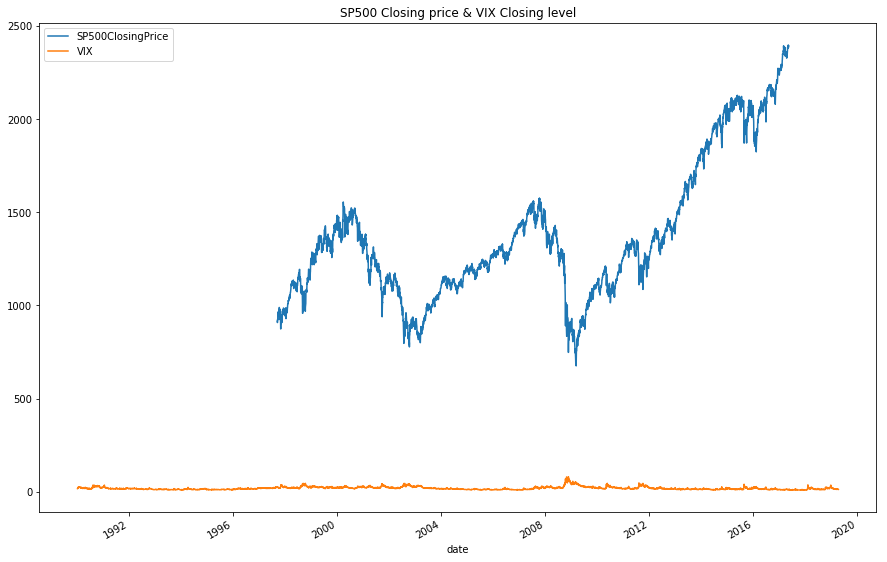

In [61]:
sp500closing.plot(figsize= (15,10))
VIX.plot()
plt.legend()
plt.title('SP500 Closing price & VIX Closing level')
plt.show();

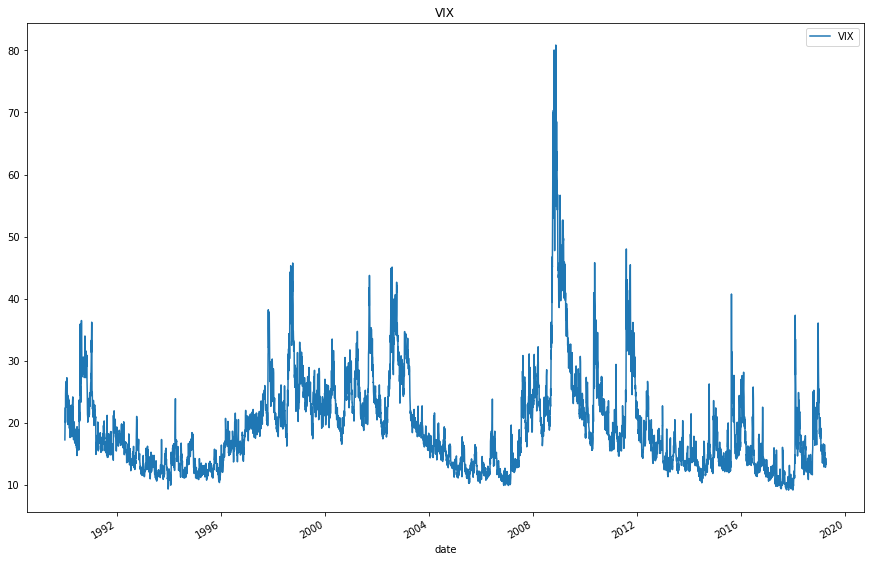

In [62]:
VIX.plot(figsize= (15,10))
plt.legend()
plt.title('VIX')
plt.show();

# Dickey Fuller Test on SP500 & VIX
    Fuller test and observation of chart shows SP500 not stationary. ??Surprise??

In [63]:
print( f" Pvalue for DickeyFuller test of closing prices is {adfuller(sp500closing)[1]} \n Conclusion: Data is not stationary.")

 Pvalue for DickeyFuller test of closing prices is 0.15577734017871037 
 Conclusion: Data is not stationary.


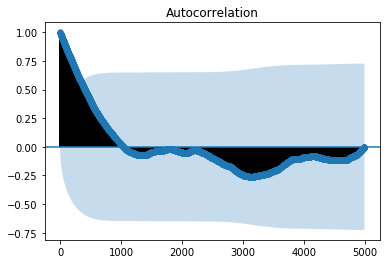

In [64]:
plot_acf(sp500closing);

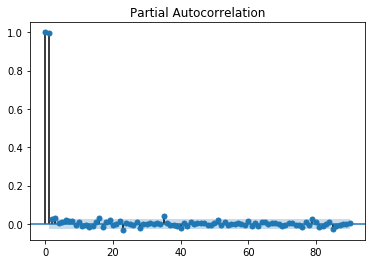

In [65]:
plot_pacf(sp500closing, lags= 90);

In [66]:
lag1daydiff = sp500closing.diff(periods= 1).dropna()

In [67]:
lag1daydiff.head()

Date
2017-05-11    2.25
2017-05-10    4.25
2017-05-09   -2.00
2017-05-08    1.75
2017-05-05    2.75
Name: SP500ClosingPrice, dtype: float64

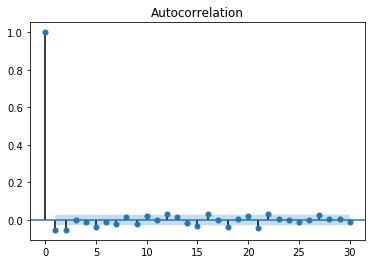

In [68]:
plot_acf(lag1daydiff, lags= 30);

## VIX is stationary

In [69]:
print( f" Pvalue for DickeyFuller test of VIX is {adfuller(VIX)[1]} \n Conclusion: VIX Data is stationary.")

 Pvalue for DickeyFuller test of VIX is 2.143401700412233e-06 
 Conclusion: VIX Data is stationary.


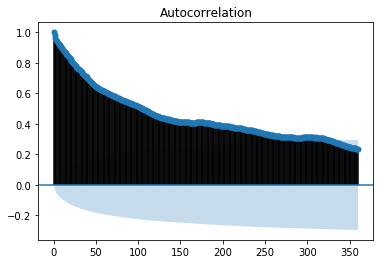

In [70]:
plot_acf(VIX, lags = 360);

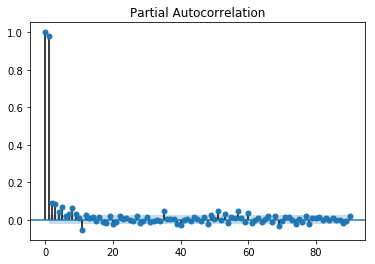

In [71]:
plot_pacf(VIX, lags= 90);

# Moving Averages & Stationarizing SP500 futures data

In [72]:
sp500rollingmean30 = sp500closing.rolling(30).mean()
sp500rollingstd30 = sp500closing.rolling(30).std()

sp500rollingmean30.dropna(inplace= True)
sp500rollingstd30.dropna(inplace= True)

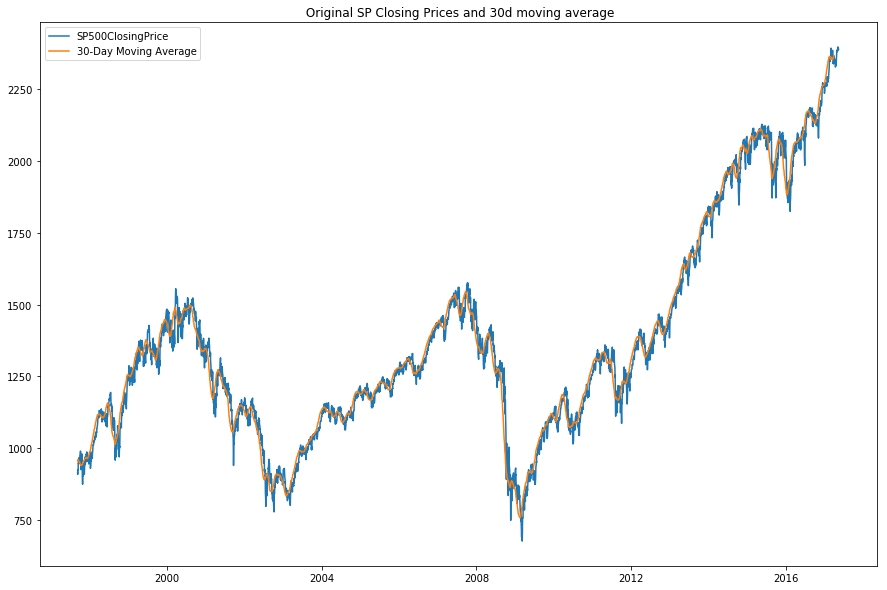

In [73]:
plt.figure(figsize=(15,10))
plt.plot(sp500closing)
plt.plot(sp500rollingmean30, label = '30-Day Moving Average')
plt.legend()
plt.title(" Original SP Closing Prices and 30d moving average")
plt.show();

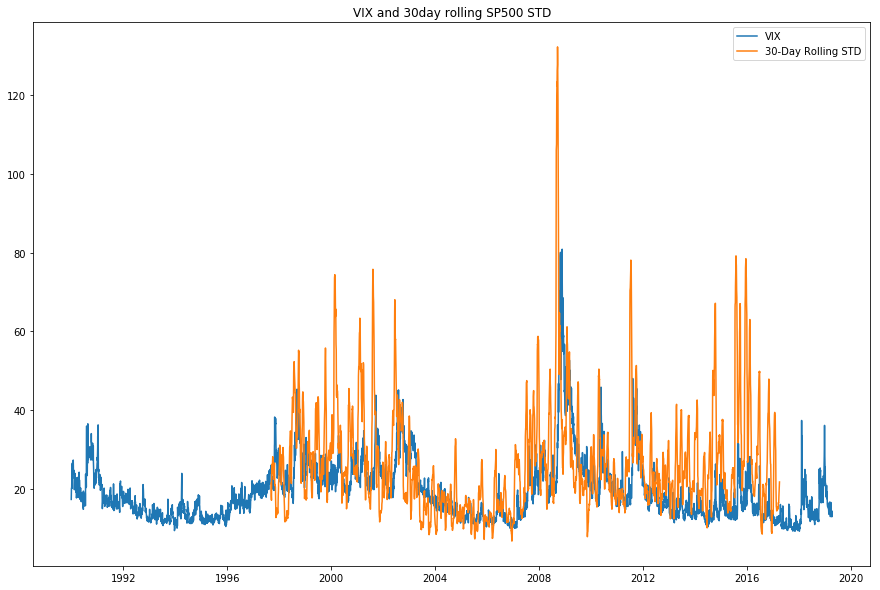

In [74]:
plt.figure(figsize=(15,10))
plt.plot(VIX)
plt.plot(sp500rollingstd30, label = '30-Day Rolling STD')
plt.legend()
plt.title("VIX and 30day rolling SP500 STD")
plt.show();

## Transforming the Data

In [75]:
logsp500= np.log(sp500closing)

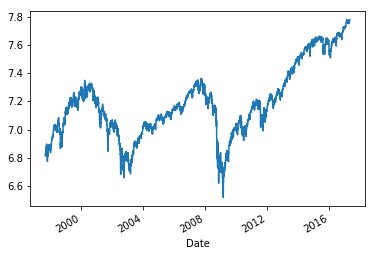

In [76]:
logsp500.plot();

In [77]:
logminusrollingmean = logsp500 - logsp500.rolling(30).mean()

In [78]:
logrollingstd= logsp500.rolling(30).std()

In [79]:
logrollingstd.dropna(inplace= True)

In [80]:
logminusrollingmean.dropna(inplace= True)

In [81]:
print( f" Pvalue for DickeyFuller test of Logdifference SP500 is {adfuller(logminusrollingmean)[1]} \n Conclusion: Data is stationary.")



 Pvalue for DickeyFuller test of Logdifference SP500 is 2.8308457281101394e-21 
 Conclusion: Data is stationary.


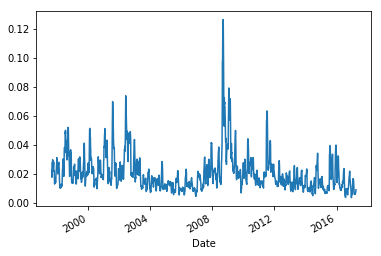

In [82]:
logrollingstd.plot();

In [83]:
VIX.plot()

!pip install stldecompose

# Decomposition

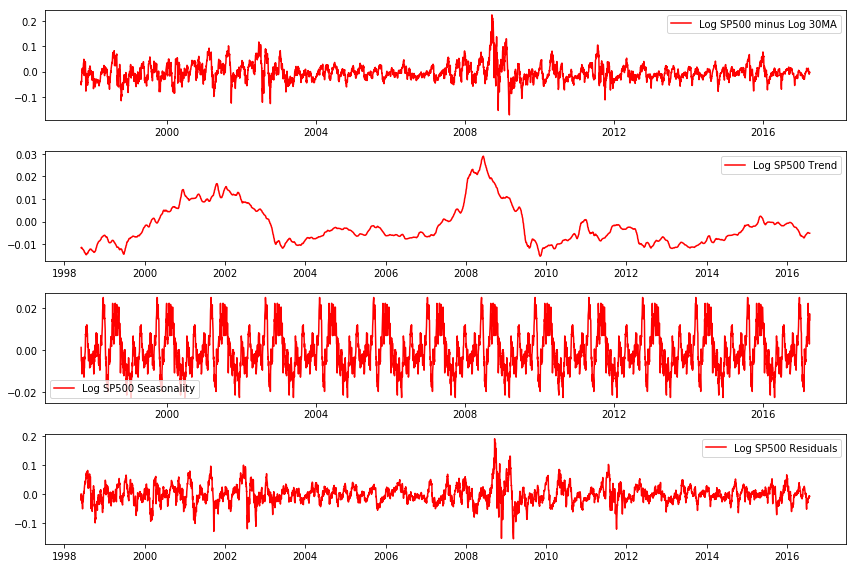

In [84]:
# import seasonal_decompose
decomposition = seasonal_decompose(logminusrollingmean, model= 'additive', freq=365)

# Gather the trend, seasonality and noise of decomposed object
logsptrend = decomposition.trend
logspseasonal = decomposition.seasonal
logspresidual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(logminusrollingmean, label='Log SP500 minus Log 30MA', color="red")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(logsptrend, label='Log SP500 Trend', color="red")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(logspseasonal,label='Log SP500 Seasonality', color="red")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(logspresidual, label='Log SP500 Residuals', color="red")
plt.legend(loc='best')
plt.tight_layout()

In [85]:
spdecomposedf= pd.concat({'Log SP500 minus Log 30MA': logminusrollingmean,'Log SP500 Trend': pd.Series(logsptrend), 'Log SP500 Seasonal' : pd.Series(logspseasonal), 'LogSP500 Residual' :pd.Series(logspresidual)}, axis=1).dropna()




In [86]:
spdecomposedf.head()

Log SP500 Seasonal  Log SP500 Trend  Log SP500 minus Log 30MA  \
Date                                                                        
2016-07-25            0.007481        -0.005222                 -0.004763   
2016-07-22            0.009205        -0.005238                 -0.002177   
2016-07-21            0.012157        -0.005224                 -0.006427   
2016-07-20            0.009081        -0.005193                 -0.002004   
2016-07-19            0.006594        -0.005166                 -0.005795   

            LogSP500 Residual  
Date                           
2016-07-25          -0.007022  
2016-07-22          -0.006144  
2016-07-21          -0.013359  
2016-07-20          -0.005891  
2016-07-19          -0.007223

In [87]:
# import seasonal_decompose
decomposition = seasonal_decompose(VIX, model= 'additive', freq=365)

# Gather the trend, seasonality and noise of decomposed object
vixtrend = decomposition.trend
vixseasonal = decomposition.seasonal
vixresidual = decomposition.resid

# Plot gathered statistics
plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(VIX, label='VIX', color="green")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(vixtrend, label='VIX Trend', color="green")
plt.legend(loc='best')
plt.subplot(413)
plt.plot(vixseasonal,label='VIX Seasonality', color="green")
plt.legend(loc='best')
plt.subplot(414)
plt.plot(vixresidual, label='VIX Residuals', color="green")
plt.legend(loc='best')
plt.tight_layout()

In [88]:
vixdecomposedf= pd.concat({'VIX': VIX,'VIX Trend': pd.Series(vixtrend), 'VIX Seasonal' : pd.Series(vixseasonal), 'VIX Residual' :pd.Series(vixresidual)}, axis=1).dropna()




## Looking at the DataFrames

In [243]:
spdecomposedf.head()

Log SP500 Seasonal  Log SP500 Trend  Log SP500 minus Log 30MA  \
Date                                                                        
2016-07-25            0.007481        -0.005222                 -0.004763   
2016-07-22            0.009205        -0.005238                 -0.002177   
2016-07-21            0.012157        -0.005224                 -0.006427   
2016-07-20            0.009081        -0.005193                 -0.002004   
2016-07-19            0.006594        -0.005166                 -0.005795   

            LogSP500 Residual  
Date                           
2016-07-25          -0.007022  
2016-07-22          -0.006144  
2016-07-21          -0.013359  
2016-07-20          -0.005891  
2016-07-19          -0.007223

In [244]:
vixdecomposedf.head()

VIX  VIX Residual  VIX Seasonal  VIX Trend
date                                                    
1990-09-20  28.66      6.901244     -0.368860  22.127616
1990-09-21  30.04      8.088733     -0.175664  22.126932
1990-09-24  30.56      8.846400     -0.407277  22.120877
1990-09-25  28.81      6.873841     -0.174526  22.110685
1990-09-26  28.19      6.444945     -0.354754  22.099808

In [262]:
combined = spdecomposedf.join([vixdecomposedf, sp500closing])

In [263]:
combined.dropna(inplace= True)

In [264]:
combined.head()

Log SP500 Seasonal  Log SP500 Trend  Log SP500 minus Log 30MA  \
Date                                                                        
2016-07-25            0.007481        -0.005222                 -0.004763   
2016-07-22            0.009205        -0.005238                 -0.002177   
2016-07-21            0.012157        -0.005224                 -0.006427   
2016-07-20            0.009081        -0.005193                 -0.002004   
2016-07-19            0.006594        -0.005166                 -0.005795   

            LogSP500 Residual    VIX  VIX Residual  VIX Seasonal  VIX Trend  \
Date                                                                          
2016-07-25          -0.007022  12.87     -2.485985      0.131629  15.224356   
2016-07-22          -0.006144  12.02     -3.580552      0.378634  15.221918   
2016-07-21          -0.013359  12.74     -2.821550      0.342810  15.218740   
2016-07-20          -0.005891  11.77     -3.194809     -0.251904  15.216712   
2016-07-19          -0.007223  11.97     -3.264122      0.013629  15.220493   

            SP500ClosingPrice  
Date                           
2016-07-25            2162.25  
2016-07-22            2167.50  
2016-07-21            2158.00  
2016-07-20            2167.50  
2016-07-19            2158.75

## Granger Causality

The Null hypothesis for grangercausalitytests is that the time series in the second column, x2, does NOT Granger cause the time series in the first column, x1. Grange causality means that past values of x2 have a statistically significant effect on the current value of x1, taking past values of x1 into account as regressors. We reject the null hypothesis that x2 does not Granger cause x1 if the pvalues are below a desired size of the test.

In [265]:
print(grangercausalitytests(combined[['VIX','Log SP500 minus Log 30MA']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.6296  , p=0.0101  , df_denom=4563, df_num=1
ssr based chi2 test:   chi2=6.6339  , p=0.0100  , df=1
likelihood ratio test: chi2=6.6291  , p=0.0100  , df=1
parameter F test:         F=6.6296  , p=0.0101  , df_denom=4563, df_num=1
{1: ({'ssr_ftest': (6.629561002044889, 0.01006122694008476, 4563.0, 1), 'ssr_chi2test': (6.633919687779303, 0.010005485567349507, 1), 'lrtest': (6.62910515537078, 0.010032565239650381, 1), 'params_ftest': (6.629561002046024, 0.010061226940080381, 4563.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c397c0390>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c397c09b0>, array([[0., 1., 0.]])])}


>####  Reject null hypothesis. Stationarized SP500 does cause VIX... Duh makes sense!

## Experiment VIX @ (t-30) with SP @ (t)

In [267]:
VIXSPshift = combined[['VIX','Log SP500 minus Log 30MA']]

In [268]:
VIXSPshift.head()

VIX  Log SP500 minus Log 30MA
Date                                       
2016-07-25  12.87                 -0.004763
2016-07-22  12.02                 -0.002177
2016-07-21  12.74                 -0.006427
2016-07-20  11.77                 -0.002004
2016-07-19  11.97                 -0.005795

#### Shift VIX column back one day

In [269]:
VIXSPshift['VIX']= VIXSPshift['VIX'].shift(30)

In [270]:
VIXSPshift.rename(columns= {'VIX':'VIXtminus30'},inplace= True)

In [271]:
VIXSPshift.dropna(inplace= True)

In [272]:
VIXSPshift.head()

VIXtminus30  Log SP500 minus Log 30MA
Date                                             
2016-06-10        12.87                 -0.000005
2016-06-09        12.02                  0.009374
2016-06-08        12.74                  0.011781
2016-06-07        11.77                  0.008892
2016-06-06        11.97                  0.008640

In [276]:
print(grangercausalitytests(VIXSPshift[['Log SP500 minus Log 30MA','VIXtminus30']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=23.9811 , p=0.0000  , df_denom=4533, df_num=1
ssr based chi2 test:   chi2=23.9969 , p=0.0000  , df=1
likelihood ratio test: chi2=23.9337 , p=0.0000  , df=1
parameter F test:         F=23.9811 , p=0.0000  , df_denom=4533, df_num=1
{1: ({'ssr_ftest': (23.98107510777059, 1.006723157538888e-06, 4533.0, 1), 'ssr_chi2test': (23.996946103871032, 9.648862300118344e-07, 1), 'lrtest': (23.93369318542682, 9.97112918904933e-07, 1), 'params_ftest': (23.981075107771872, 1.0067231575381493e-06, 4533.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c39774da0>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x1c39769710>, array([[0., 1., 0.]])])}


In [277]:
grangercausalitytests(VIXSPshift[['Log SP500 minus Log 30MA','VIXtminus30']].dropna(),1, verbose= False)[1][0]['ssr_ftest'][1]

1.006723157538888e-06

## Tried a function to find a sweet spot... what we found is that there is a strong causal relationship regardless of many shifts back we take

def shifter(vs, counter = 0):
    while grangercausalitytests(vs[['Log SP500 minus Log 30MA','VIX']].dropna(),1, verbose= False )[1][0]['ssr_ftest'][1] < 0.000001:
        vs['VIX'] = vs['VIX'].shift(1)
        vs['VIX'] = vs['VIX'].dropna(inplace= True)
        counter += 1
    return vs, counter
vs, counter= shifter(VIXSPshift)
print(counter)






# ARIMA Model SP500

In [278]:
rcParams['figure.figsize']= 14,5
log500minus = spdecomposedf['Log SP500 minus Log 30MA']
plot_acf(log500minus, lags=100);

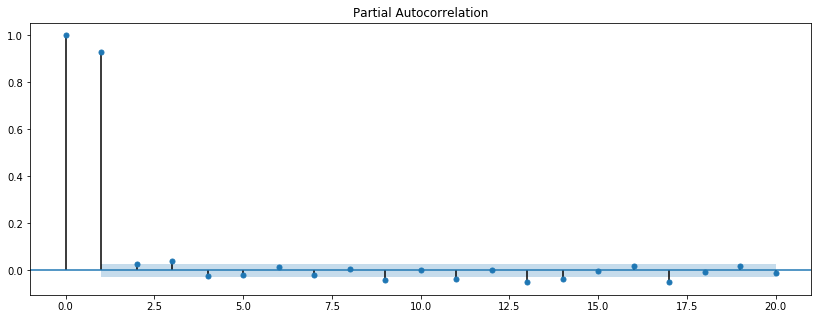

In [279]:
rcParams['figure.figsize']= 14,5
log500minus = spdecomposedf['Log SP500 minus Log 30MA']
plot_pacf(log500minus, lags=20);

In [309]:
series.describe()

count    4537.000000
mean       -0.001970
std         0.033362
min        -0.170403
25%        -0.020893
50%        -0.006066
75%         0.014420
max         0.223183
Name: Log SP500 minus Log 30MA, dtype: float64

In [310]:
exogVIX30shift.describe()

count    4537.000000
mean       21.039751
std         8.677094
min         9.890000
25%        14.670000
50%        19.350000
75%        24.830000
max        80.860000
Name: VIXtminus30, dtype: float64

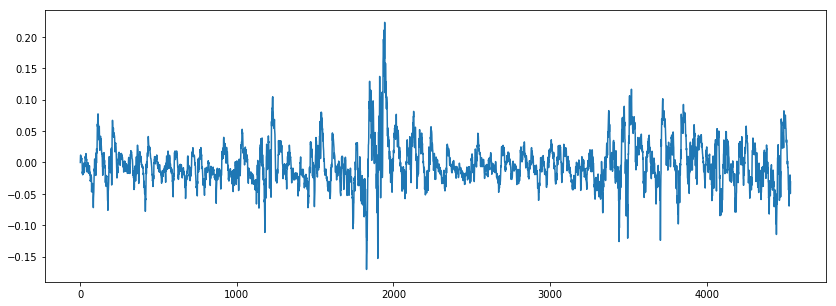

In [345]:
plt.plot(series)

In [343]:
from sklearn import preprocessing

series = VIXSPshift['Log SP500 minus Log 30MA'].values #returns a numpy array

In [344]:
series

array([-5.22501994e-06,  9.37402350e-03,  1.17813678e-02, ...,
       -3.49313622e-02, -4.95325088e-02, -3.08649021e-02])

In [347]:
VIXSPshift.tail()

VIXtminus30  Log SP500 minus Log 30MA
Date                                             
1998-06-08        20.10                 -0.022535
1998-06-05        17.34                 -0.019895
1998-06-04        16.23                 -0.034931
1998-06-03        16.97                 -0.049533
1998-06-02        17.89                 -0.030865

In [388]:
# Normalize total_bedrooms column
LogSP_array = np.array(VIXSPshift['Log SP500 minus Log 30MA'])
VIXtminus30_array = np.array(VIXSPshift['VIXtminus30'])

min_max_scalerLog = preprocessing.MinMaxScaler()
LogSP_scaled = min_max_scalerLog.fit_transform(LogSP_array.reshape(-1, 1))

min_max_scalerVIX = preprocessing.MinMaxScaler()
VIX_scaled = min_max_scalerVIX.fit_transform(VIXtminus30_array.reshape(-1, 1))

# normalized_Log = preprocessing.normalize([LogSP_array])
# normalized_VIX = preprocessing.normalize([VIXtminus30_array])

In [382]:
normalized_Log

array([[-2.32134107e-06,  4.16463593e-03,  5.23415666e-03, ...,
        -1.55190998e-02, -2.20060112e-02, -1.37124768e-02]])

In [393]:
VIXSPshift['normalized_Log']= normalized_Log.flatten()
VIXSPshift['normalized_VIX']= normalized_VIX.flatten()

VIXSPshift['Standardized_LogSP']= LogSP_scaled.flatten()
VIXSPshift['Standardized_VIXtminus30']= VIX_scaled.flatten()

In [394]:
VIXSPshift.head()

VIXtminus30  Log SP500 minus Log 30MA  normalized_Log  \
Date                                                                
2016-06-10        12.87                 -0.000005       -0.000002   
2016-06-09        12.02                  0.009374        0.004165   
2016-06-08        12.74                  0.011781        0.005234   
2016-06-07        11.77                  0.008892        0.003951   
2016-06-06        11.97                  0.008640        0.003839   

            normalized_VIX  Standardized_Log  Standardized_VIX  \
Date                                                             
2016-06-10        0.008396          0.432936          0.041990   
2016-06-09        0.007841          0.456766          0.030013   
2016-06-08        0.008311          0.462883          0.040158   
2016-06-07        0.007678          0.455542          0.026490   
2016-06-06        0.007808          0.454902          0.029308   

            Standardized_LogSP  Standardized_VIXtminus30  
Date                                                      
2016-06-10            0.432936                  0.041990  
2016-06-09            0.456766                  0.030013  
2016-06-08            0.462883                  0.040158  
2016-06-07            0.455542                  0.026490  
2016-06-06            0.454902                  0.029308

# More like it! After transforming and Standardizing Data

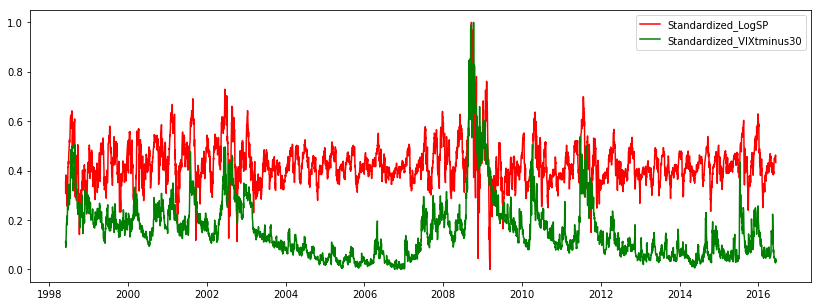

In [396]:
plt.plot(VIXSPshift['Standardized_LogSP'], color= 'red')
plt.plot(VIXSPshift['Standardized_VIXtminus30'], color= 'green')
plt.legend()
plt.show();

                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.4259      0.007     59.994      0.000       0.412       0.440
Standardized_VIXtminus30     0.0119      0.020      0.608      0.543      -0.026       0.050
ar.L1.Standardized_LogSP     0.9271      0.006    160.369      0.000       0.916       0.938


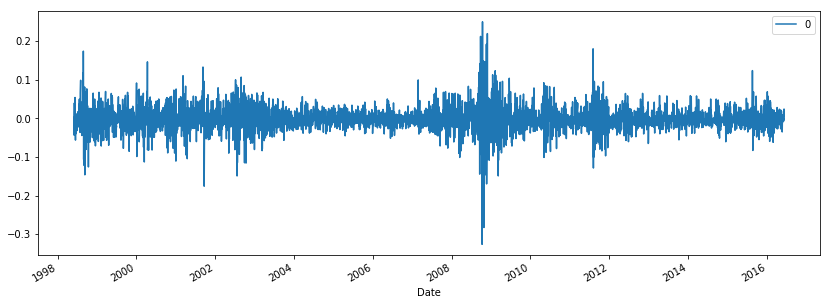

                 0
count  4537.000000
mean     -0.000001
std       0.031537
min      -0.326153
25%      -0.014972
50%      -0.001089
75%       0.014216
max       0.250514


In [398]:
series= VIXSPshift['Standardized_LogSP']
exogVIX30shift= VIXSPshift['Standardized_VIXtminus30']
model = ARIMA(endog=series,exog=exogVIX30shift, order=(1,0,0))
model_fit = model.fit(disp=0)
print(model_fit.summary().tables[1])
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [430]:
X1 = series.values
X2= exogVIX30shift.values
size = int(len(X1) * 0.9)
trainEndo, testEndo = X1[0:size], X1[size:]
trainExog, testExog = X2[0:size], X2[size:]


In [431]:
# define a new variable using train, but they're not the same variable
historyEndo = [x for x in trainEndo]
historyExog = [x for x in trainExog]

In [432]:
len(historyEndo)

4083

In [433]:
len(historyExog)

4083

In [434]:
#instantiate empty list
predictions = list()

for t in range(len(testEndo)):
    model = ARIMA(endog=trainEndo, exog=trainExog, order=(0,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast(steps= len(testEndo), exog= testExog)
    yhat = output[0]
    predictions.append(yhat)
    obs = testEndo[t]
    historyEndo.append(obs)

In [435]:
#     print('predicted=%f, expected=%f' % (yhat, obs))
# error = mean_squared_error(testEndo, predictions)
# print('Test MSE: %.9f' % error)
# plot
plt.plot(testEndo)
plt.plot(predictions, color='red')
plt.show()

In [252]:
error = mean_squared_error(np.exp(test), np.exp(predictions))
print(error)

0.0001824804711975998


In [253]:
plt.plot(predictions)

In [254]:
plt.plot(X)

In [255]:
print(X[:size].size)
print(X[size:].size)

4145
461


In [256]:
history = [x for x in train]

In [257]:
len(history)

4145

In [258]:
train = X[0:size]
test = X[size:]

In [259]:
len(train), len(test)

(4145, 461)

# FBProphet Forecasting Model

In [312]:
Model = proph(interval_width=0.95, daily_seasonality= True)

In [313]:
spprophet = sp500closing.reset_index()

In [314]:
spprophet.head()

Date  SP500ClosingPrice
0 2017-05-12            2388.75
1 2017-05-11            2391.00
2 2017-05-10            2395.25
3 2017-05-09            2393.25
4 2017-05-08            2395.00

In [315]:
spprophet = spprophet.rename(columns={'Date': 'ds',
                        'SP500ClosingPrice' : 'y'})

In [316]:
Model.fit(spprophet);

In [321]:
future_dates = Model.make_future_dataframe(periods=36, freq='D', include_history= True)
future_dates.tail()

ds
5030 2017-06-13
5031 2017-06-14
5032 2017-06-15
5033 2017-06-16
5034 2017-06-17

In [332]:
forecast = Model.predict(future_dates)

In [335]:
forecast.tail()

ds        trend   yhat_lower   yhat_upper  trend_lower  \
5030 2017-06-13  2281.500606  2203.481880  2423.950676  2278.965314   
5031 2017-06-14  2281.897328  2195.738401  2419.236716  2279.255982   
5032 2017-06-15  2282.294050  2198.780234  2435.779895  2279.446388   
5033 2017-06-16  2282.690772  2201.515200  2425.545579  2279.524015   
5034 2017-06-17  2283.087494  2189.254938  2406.138231  2279.601642   

      trend_upper  additive_terms  additive_terms_lower  additive_terms_upper  \
5030  2289.584212       30.381889             30.381889             30.381889   
5031  2290.408211       29.548030             29.548030             29.548030   
5032  2291.221509       29.277691             29.277691             29.277691   
5033  2292.595236       28.046806             28.046806             28.046806   
5034  2293.378515       19.932255             19.932255             19.932255   

          daily     ...         weekly  weekly_lower  weekly_upper     yearly  \
5030  15.271341     ...       5.028893      5.028893      5.028893  10.081656   
5031  15.271341     ...       5.042456      5.042456      5.042456   9.234233   
5032  15.271341     ...       5.650851      5.650851      5.650851   8.355500   
5033  15.271341     ...       5.313802      5.313802      5.313802   7.461663   
5034  15.271341     ...      -1.908916     -1.908916     -1.908916   6.569830   

      yearly_lower  yearly_upper  multiplicative_terms  \
5030     10.081656     10.081656                   0.0   
5031      9.234233      9.234233                   0.0   
5032      8.355500      8.355500                   0.0   
5033      7.461663      7.461663                   0.0   
5034      6.569830      6.569830                   0.0   

      multiplicative_terms_lower  multiplicative_terms_upper         yhat  
5030                         0.0                         0.0  2311.882495  
5031                         0.0                         0.0  2311.445358  
5032                         0.0                         0.0  2311.571741  
5033                         0.0                         0.0  2310.737578  
5034                         0.0                         0.0  2303.019749  

[5 rows x 22 columns]

In [328]:
sp500closing.head()

Date
2017-05-12    2388.75
2017-05-11    2391.00
2017-05-10    2395.25
2017-05-09    2393.25
2017-05-08    2395.00
Name: SP500ClosingPrice, dtype: float64

In [323]:
Model.plot(forecast, uncertainty=True)
plt.show()

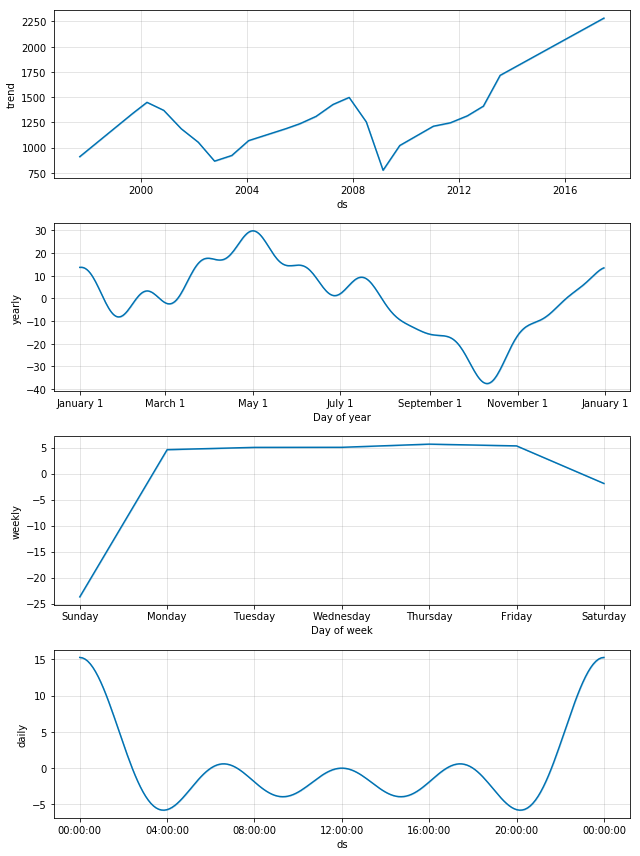

In [324]:
Model.plot_components(forecast)
plt.show()

In [338]:
df_cv = cross_validation(Model, initial='730 days', period='180 days', horizon = '365 days')
df_cv.head()

INFO:fbprophet.diagnostics:Making 34 forecasts with cutoffs between 2000-02-06 00:00:00 and 2016-05-12 00:00:00


ds         yhat   yhat_lower   yhat_upper        y     cutoff
0 2000-02-07  1452.833419  1408.697786  1500.386973  1427.25 2000-02-06
1 2000-02-08  1454.007215  1409.512992  1501.115646  1446.25 2000-02-06
2 2000-02-09  1455.454925  1408.333771  1498.339881  1418.25 2000-02-06
3 2000-02-10  1455.904910  1410.047734  1505.204641  1419.25 2000-02-06
4 2000-02-11  1458.838941  1412.959684  1500.485548  1396.75 2000-02-06

In [340]:
perfmet = performance_metrics(df_cv)

In [342]:
perfmet.head()

horizon           mse        rmse        mae      mape  coverage
4549 37 days  17450.005966  132.098471  99.495414  0.078989  0.552723
1780 37 days  17483.254136  132.224257  99.664277  0.079168  0.551564
6829 37 days  17486.547427  132.236710  99.682531  0.079191  0.551564
7609 37 days  17463.134267  132.148153  99.580086  0.079128  0.552723
1527 37 days  17445.709493  132.082207  99.443588  0.079049  0.553882

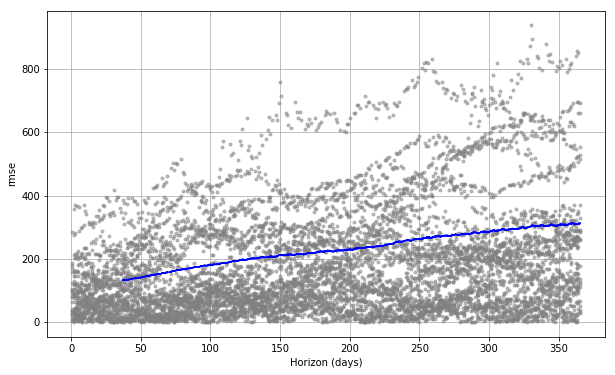

In [346]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

# Running LSTM - RNN Model on VIX

### Preparing the data

In [4]:
#converts series matrix like 
def convertSeriesToMatrix(vectorSeries, sequence_length):
    matrix=[]
    for i in range(len(vectorSeries)-sequence_length+1):
        matrix.append(vectorSeries[i:i+sequence_length])
    return matrix
        

In [5]:
path_to_dataset = 'vix-volatility-index.csv'
sequence_length = 30

In [6]:
vector_vix = []
with open(path_to_dataset) as f:
    next(f) # skip the header row
    for line in f:
        fields = line.split(',')
        vector_vix.append(float(fields[1]))

In [7]:
len(vector_vix)

7373

In [8]:
matrix_vix = convertSeriesToMatrix(vector_vix, sequence_length)

In [9]:
matrix_vix

[[17.24,
  18.19,
  19.22,
  20.11,
  20.26,
  22.2,
  22.44,
  20.05,
  24.64,
  26.34,
  24.18,
  24.16,
  24.34,
  22.5,
  26.7,
  24.72,
  25.39,
  25.63,
  26.28,
  26.44,
  27.25,
  25.36,
  24.87,
  24.32,
  24.54,
  24.69,
  24.29,
  23.77,
  23.69,
  24.38],
 [18.19,
  19.22,
  20.11,
  20.26,
  22.2,
  22.44,
  20.05,
  24.64,
  26.34,
  24.18,
  24.16,
  24.34,
  22.5,
  26.7,
  24.72,
  25.39,
  25.63,
  26.28,
  26.44,
  27.25,
  25.36,
  24.87,
  24.32,
  24.54,
  24.69,
  24.29,
  23.77,
  23.69,
  24.38,
  23.76],
 [19.22,
  20.11,
  20.26,
  22.2,
  22.44,
  20.05,
  24.64,
  26.34,
  24.18,
  24.16,
  24.34,
  22.5,
  26.7,
  24.72,
  25.39,
  25.63,
  26.28,
  26.44,
  27.25,
  25.36,
  24.87,
  24.32,
  24.54,
  24.69,
  24.29,
  23.77,
  23.69,
  24.38,
  23.76,
  22.05],
 [20.11,
  20.26,
  22.2,
  22.44,
  20.05,
  24.64,
  26.34,
  24.18,
  24.16,
  24.34,
  22.5,
  26.7,
  24.72,
  25.39,
  25.63,
  26.28,
  26.44,
  27.25,
  25.36,
  24.87,
  24.32,
  24.54,
 

In [10]:
matrix_vix = np.array(matrix_vix)
shifted_value = matrix_vix.mean()
matrix_vix -= shifted_value
print("Data  shape: ", matrix_vix.shape)

Data  shape:  (7344, 30)


In [11]:
train_row = int(round(0.9 * matrix_vix.shape[0]))
train_set = matrix_vix[:train_row, :]

In [12]:
train_set.shape

(6610, 30)

In [13]:
np.random.seed(1234)

np.random.shuffle(train_set)
# the training set
X_train = train_set[:, :-1]
# the last column is the true value to compute the mean-squared-error loss
y_train = train_set[:, -1] 
# the test set
X_test = matrix_vix[train_row:, :-1]
y_test = matrix_vix[train_row:, -1]

In [14]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

### Building the Model

In [15]:
model= Sequential()

#layer1: LSTM
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(.2))

#layer 2: LSTM
model.add(LSTM(units=100, return_sequences= False))
model.add(Dropout(.2))

#layer 3: dense
#linear activation: a(x)=x
model.add(Dense(units=1, activation="linear"))

#compile the model
model.compile(loss= "mse", optimizer= "rmsprop")

In [39]:
model.fit(X_train, y_train, batch_size=512, nb_epoch=50, validation_split=0.05, verbose=1)

# save model to single file
# model.save('VIXrnn.h5')

/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


Train on 6279 samples, validate on 331 samples
Epoch 1/50
6279/6279 [==============================] - 4s 589us/step - loss: 33.2288 - val_loss: 22.2805
Epoch 2/50
6279/6279 [==============================] - 2s 383us/step - loss: 17.3154 - val_loss: 17.5150
Epoch 3/50
6279/6279 [==============================] - 2s 390us/step - loss: 14.1465 - val_loss: 16.5631
Epoch 4/50
6279/6279 [==============================] - 2s 382us/step - loss: 12.0583 - val_loss: 14.0278
Epoch 5/50
6279/6279 [==============================] - 2s 384us/step - loss: 10.6942 - val_loss: 12.3396
Epoch 6/50
6279/6279 [==============================] - 2s 383us/step - loss: 9.6640 - val_loss: 11.4286
Epoch 7/50
6279/6279 [==============================] - 2s 383us/step - loss: 8.8103 - val_loss: 10.6059
Epoch 8/50
6279/6279 [==============================] - 2s 391us/step - loss: 8.0790 - val_loss: 10.0546
Epoch 9/50
6279/6279 [==============================] - 3s 402us/step - loss: 7.5246 - val_loss: 10.2306
Epo

In [16]:
test_mse = model.evaluate(X_test, y_test, verbose=1)
print('\nThe mean squared error (MSE) on the test data set is %.3f over %d test samples.' % (test_mse, len(y_test)))

/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


734/734 [==============================] - 1s 883us/step

The mean squared error (MSE) on the test data set is 40.838 over 734 test samples.


In [21]:
predicted_values = model.predict(X_test)
num_test_samples = len(predicted_values)
predicted_values = np.reshape(predicted_values, (num_test_samples,1))

In [22]:
# fig = plt.figure()
actual, = plt.plot(y_test + shifted_value, label= 'Actual')
predicted, = plt.plot(predicted_values + shifted_value, label = 'Predicted')
plt.xlabel('Date')
plt.ylabel('VIX')
plt.legend()
# plt.savefig('VIX output_prediction.jpg', bbox_inches='tight')
plt.show()


In [19]:
from keras.models import load_model
# load model from single file
model = load_model('VIXrnn.h5')
# make predictions
yhat = model.predict(X_test, verbose=0)
print(yhat)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:560: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  return np.fromstring(tensor.tensor_content, dtype=dtype).reshape(shape)
/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/util/tf_inspect.py:45: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() or inspect.getfullargspec()
  if d.decorator_argspec is not None), _inspect.getargspec(target))


[[-5.39189   ]
 [-4.4771247 ]
 [-4.7528167 ]
 [-4.1763034 ]
 [-4.4831786 ]
 [-3.6861312 ]
 [-3.3345902 ]
 [-2.964029  ]
 [-3.8925607 ]
 [-3.3962834 ]
 [-4.587761  ]
 [-5.116812  ]
 [-5.590088  ]
 [-5.902568  ]
 [-4.969536  ]
 [-4.9976583 ]
 [-5.47013   ]
 [-5.619045  ]
 [-5.48109   ]
 [-5.1428556 ]
 [-5.11646   ]
 [-4.607702  ]
 [-2.530237  ]
 [ 0.8073644 ]
 [ 0.57603216]
 [ 0.20699333]
 [-0.38164455]
 [-0.31061876]
 [-1.1133904 ]
 [-1.0236917 ]
 [ 1.4448471 ]
 [-1.4227607 ]
 [ 4.6878686 ]
 [ 3.746924  ]
 [ 0.12712936]
 [-2.2617755 ]
 [-3.5614877 ]
 [-4.401979  ]
 [-3.706358  ]
 [-4.1392903 ]
 [-4.324968  ]
 [-5.682428  ]
 [-5.4970512 ]
 [-5.5285187 ]
 [-5.9919233 ]
 [-6.201542  ]
 [-6.3595796 ]
 [-6.5824733 ]
 [-6.9956293 ]
 [-7.176441  ]
 [-6.381456  ]
 [-7.0453978 ]
 [-6.29389   ]
 [-6.1910367 ]
 [-6.3565626 ]
 [-6.4320045 ]
 [-7.1284437 ]
 [-6.6509233 ]
 [-5.9138217 ]
 [-6.3534117 ]
 [-6.684232  ]
 [-7.5054355 ]
 [-7.4331217 ]
 [-7.3674417 ]
 [-7.0787663 ]
 [-7.3848224 ]
 [-7.46926

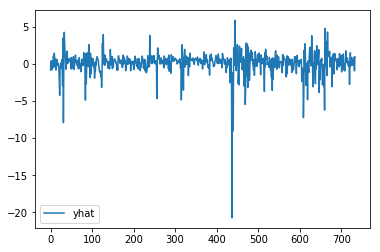

In [31]:
diff= []

for i in range(len(yhat)):
    diff.append(yhat[i]-y_test[i])
    
plt.plot(diff, label= "yhat")
plt.legend()
plt.show();

In [35]:
X_test.shape

(734, 29, 1)

In [36]:
X_test[0,:,:]

array([[-5.29873125],
       [-6.14873125],
       [-5.12873125],
       [-3.82873125],
       [-5.15873125],
       [-3.08873125],
       [-3.88873125],
       [-2.98873125],
       [-4.39873125],
       [-5.40873125],
       [-5.52873125],
       [-5.62873125],
       [-5.89873125],
       [-6.00873125],
       [-5.96873125],
       [-5.29873125],
       [-6.02873125],
       [-5.16873125],
       [-5.28873125],
       [-5.47873125],
       [-4.02873125],
       [-3.54873125],
       [-4.56873125],
       [-3.64873125],
       [-3.19873125],
       [-3.33873125],
       [-4.52873125],
       [-4.67873125],
       [-5.61873125]])

In [40]:
y_pred_test_lstm = model.predict(X_test)
y_train_pred_lstm = model.predict(X_train)
print("The R2 score on the Train set is:\t{:0.3f}".format(r2_score(y_train, y_train_pred_lstm)))
print("The R2 score on the Test set is:\t{:0.3f}".format(r2_score(y_test, y_pred_test_lstm)))

The R2 score on the Train set is:	0.963
The R2 score on the Test set is:	0.866
